In [112]:
# load required packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from sklearn.feature_extraction import DictVectorizer # for one-hot encoding

# linear model
from sklearn.linear_model import LogisticRegression

# tree-based models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier # optional really

# model evaluation and parameter tuning
from sklearn.tree import export_text
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc  
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm.auto import tqdm # not sure if necessary

np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In [107]:
# fetch data
# dataset kaggle url: https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction
# --> downloaded, then manually uploaded via jupyter notebook to respository folder
#raw_train = pd.read_csv('train.csv')
#raw_test = pd.read_csv('test.csv')
# the dataset comes from kaggle is split into "train" and "test"
# but "test" does not contain Reponse --> will start with "train" only here
df = pd.read_csv('train.csv').drop(columns='id')
df.head()

#df.dtypes

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [64]:
# split into train/test/valid right from the beginning, even before EDA
# want 60/20/20 train/test/valid split
from sklearn.model_selection import train_test_split
df_train_full, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state=30)
df_train, df_valid = train_test_split(df_train_full, train_size = 0.75, test_size = 0.25, random_state=11)
y_train = df_train.Response#.values
y_test = df_train.Response#.values
y_valid = df_valid.Response#.values

In [65]:
# EDA

In [66]:
print('The full dataframe contains', df.shape[0], 'observations and', df.shape[1], 'columns')
print('The columns are \n', df.columns.values.tolist())

The full dataframe contains 381109 observations and 11 columns
The columns are 
 ['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']


In [67]:
print('The train dataframe contains', df_train.shape[0], 'observations and', df_train.shape[1], 'columns')
print('The columns are \n', df_train.columns.values.tolist())

The train dataframe contains 228665 observations and 11 columns
The columns are 
 ['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']


<AxesSubplot:ylabel='None'>

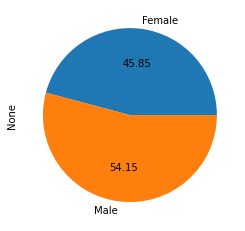

In [68]:
# univariate EDA
# Gender
df_train.groupby('Gender').size().plot(kind='pie', autopct='%.2f')
# 46% female, 54% male

<AxesSubplot:xlabel='Age'>

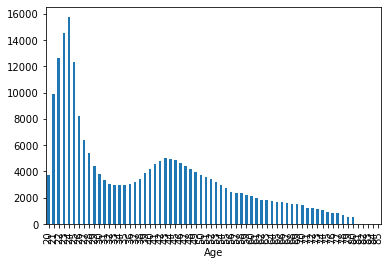

In [69]:
# Age
df_train.groupby('Age').size().plot(kind='bar')
# most people in mid-20s and mid-40s

<AxesSubplot:>

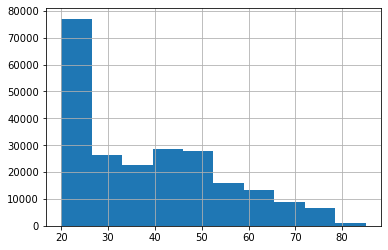

In [70]:
df_train.Age.hist()

<AxesSubplot:ylabel='None'>

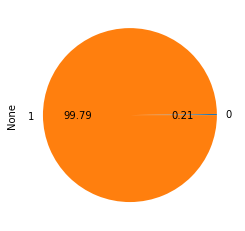

In [71]:
# Driving_License
df_train.groupby('Driving_License').size().plot(kind='pie', autopct='%.2f')
# almost no people without license -- makes sense given context

28.0    63617
8.0     20261
46.0    12003
41.0    10969
15.0     7991
30.0     7277
29.0     6645
50.0     6093
11.0     5592
3.0      5588
36.0     5300
33.0     4583
47.0     4378
35.0     4172
6.0      3801
45.0     3426
37.0     3321
18.0     3062
14.0     2825
39.0     2801
48.0     2773
10.0     2683
21.0     2532
13.0     2483
2.0      2420
7.0      1973
12.0     1875
9.0      1824
27.0     1688
32.0     1673
43.0     1588
26.0     1553
25.0     1539
17.0     1534
24.0     1427
38.0     1257
0.0      1210
23.0     1208
31.0     1186
20.0     1180
16.0     1180
49.0     1111
4.0      1097
34.0     1004
19.0      920
22.0      780
40.0      776
5.0       771
1.0       604
44.0      483
42.0      353
52.0      162
51.0      113
Name: Region_Code, dtype: int64

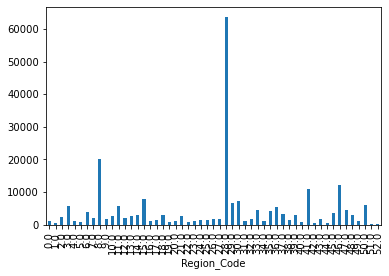

In [72]:
# Region_Code
df_train.groupby('Region_Code').size().plot(kind='bar')
# high concentration in one (most likely metropolitan) region; 60k obs there
df_train.Region_Code.value_counts()
# --> "region 28" 64k obs

<AxesSubplot:ylabel='None'>

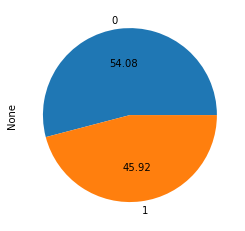

In [73]:
# Previously_Insured
df_train.groupby('Previously_Insured').size().plot(kind='pie', autopct='%.2f')
# 46% previously insured, 54% not 

<AxesSubplot:xlabel='Vehicle_Age'>

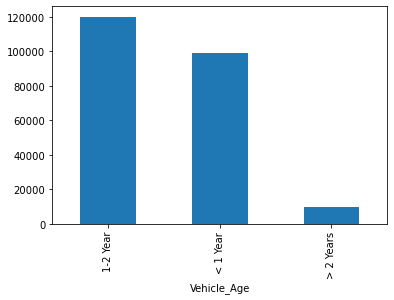

In [74]:
# Vehicle_Age
df_train.groupby('Vehicle_Age').size().plot(kind='bar')
# age only available grouped; oldest group = "> 2 Years" (!)

<AxesSubplot:ylabel='None'>

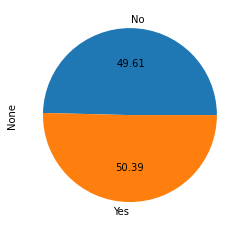

In [75]:
# Vehicle_Damage
df_train.groupby('Vehicle_Damage').size().plot(kind='pie', autopct='%.2f')
# almost exactly 50/50 split between 'previous damage' and 'no previous damange'

2630.0     39073
69856.0       84
39008.0       24
31470.0       24
29333.0       24
           ...  
19868.0        1
18285.0        1
68225.0        1
66103.0        1
72475.0        1
Name: Annual_Premium, Length: 43095, dtype: int64

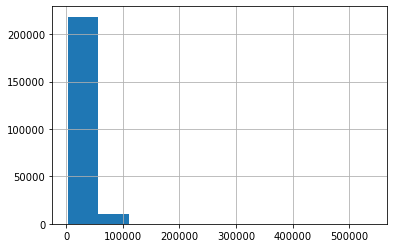

In [76]:
# Annual_Premium
df_train.Annual_Premium.hist()
# almost all annual premiums in 0-50'000 range but apparently there are also some very high outliers
df_train.Annual_Premium.value_counts()
# --> see: 39'073 obs with what appears to be some standard contract @ 2'630 premium

152.0    81041
26.0     47846
124.0    44220
160.0    13078
156.0     6405
         ...  
75.0         1
79.0         1
123.0        1
74.0         1
102.0        1
Name: Policy_Sales_Channel, Length: 152, dtype: int64

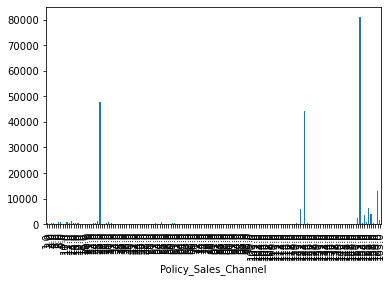

In [77]:
# Policy_Sales_Channel
df_train.groupby('Policy_Sales_Channel').size().plot(kind='bar')
# many different channels, but very high concentration around 3 (4?) main ones --> see below
df_train.Policy_Sales_Channel.value_counts()

<AxesSubplot:>

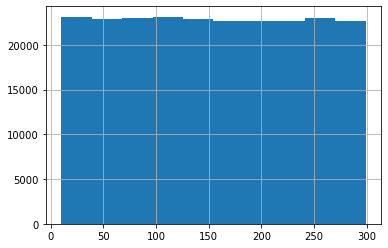

In [78]:
# Vintage
df_train.Vintage.hist()
# vintage of client relationship surprisingly evenly distributed
# the sample may have been created in a particular way to result in this distribution

<AxesSubplot:ylabel='Response'>

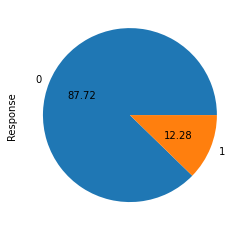

In [79]:
# Response
#df_train.groupby('Response').size().plot(kind='pie', autopct='%.2f')
# deleted Response from df_train and kept y as value so need to adjust slightly
y_train.value_counts().plot(kind='pie', autopct='%.2f')
# 12.3% of the sample 

In [80]:
# check for missing values
df_train.isna().sum()
# --> none!

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [81]:
# feature importance analysis
global_mean = y_train.mean()
global_mean

0.12277786281241117

In [82]:
categorical = ['Gender', 'Driving_License', 'Region_Code',
               'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage',
               'Policy_Sales_Channel']
for col in categorical:
    df_group = df_train_full.groupby(by=col).Response.agg(['mean'])
    df_group['n'] = df_train_full.groupby(by=col).size()
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group.sort_values('n', ascending=False))
    
# 13.8% of males take insurance vs. 10.4% of females
# 12.3% of sample with driving license take insurance vs. 5.1% of without
# region 28 (by far most represented) also has high mean of insurance takers (18.8% vs. 12.3% global mean)
# share of insurance takers among those with existing insurance ("previously insured") is next to zero
# owners of "older" vehicles opt for insurance far more often than others (who likely already have insurance?)
# those without prior damage are very unlikely to take insurance
# often observed sales channels are fairly effective (26: 19.9%, 124: 19.0%) yet most observed 152: 2.9%

,mean,n,diff,risk
Gender,,,,
Male,0.138682,164902,0.015905,1.129539
Female,0.104340,139985,-0.018438,0.849825


,mean,n,diff,risk
Driving_License,,,,
1,0.123065,304255,0.000287,1.002335
0,0.050633,632,-0.072145,0.412394


,mean,n,diff,risk
Region_Code,,,,
28.0,0.188294,84915,0.065516,1.533617
8.0,0.096143,27095,-0.026635,0.783066
46.0,0.103717,15928,-0.019061,0.844751
41.0,0.121983,14584,-0.000795,0.993526
15.0,0.071907,10611,-0.050871,0.585663
30.0,0.073994,9744,-0.048784,0.602668
29.0,0.121326,8811,-0.001452,0.988172
50.0,0.063144,8156,-0.059634,0.514292
11.0,0.113027,7423,-0.009751,0.920582


,mean,n,diff,risk
Previously_Insured,,,,
0,0.226256,165034,0.103479,1.842811
1,0.000965,139853,-0.121813,0.007862


,mean,n,diff,risk
Vehicle_Age,,,,
1-2 Year,0.174150,159983,0.051372,1.418413
< 1 Year,0.044018,132082,-0.078760,0.358518
> 2 Years,0.296366,12822,0.173588,2.413836


,mean,n,diff,risk
Vehicle_Damage,,,,
Yes,0.238457,153801,0.115680,1.942186
No,0.005295,151086,-0.117483,0.043127


,mean,n,diff,risk
Policy_Sales_Channel,,,,
152.0,0.028746,107981,-0.094032,0.234129
26.0,0.199398,63802,0.076620,1.624056
124.0,0.190262,59029,0.067485,1.549648
160.0,0.022336,17371,-0.100442,0.181923
156.0,0.216578,8505,0.093801,1.763986
...,...,...,...,...
75.0,0.000000,1,-0.122778,0.000000
50.0,0.000000,1,-0.122778,0.000000
143.0,0.000000,1,-0.122778,0.000000


In [83]:
# TODO look at AUC for numeric variables
df_train.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [84]:
# data cleaning and preparation for modeling
X_train = df_train.drop(columns='Response')
X_valid = df_valid.drop(columns='Response')
X_test = df_test.drop(columns='Response')

In [85]:
# dict transformation of categorical variables
train_dict = X_train[categorical].to_dict(orient='records')
dv = DictVectorizer(sparse=False) # initialize DictVectorizer on df that contains all relevant information
X_train = dv.fit_transform(train_dict)

valid_dict = X_valid[categorical].to_dict(orient='records')
X_valid = dv.transform(valid_dict)

test_dict = X_test[categorical].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [86]:
X_train

array([[1.000000, 0.000000, 1.000000, ..., 0.000000, 0.000000, 1.000000],
       [1.000000, 1.000000, 0.000000, ..., 0.000000, 0.000000, 1.000000],
       [1.000000, 1.000000, 0.000000, ..., 0.000000, 0.000000, 1.000000],
       ...,
       [1.000000, 0.000000, 1.000000, ..., 0.000000, 0.000000, 1.000000],
       [1.000000, 0.000000, 1.000000, ..., 0.000000, 1.000000, 0.000000],
       [1.000000, 0.000000, 1.000000, ..., 0.000000, 0.000000, 1.000000]])

In [87]:
# linear model: logistic regression

In [88]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
# solver='lbfgs' is the default solver in newer version of sklearn
# for older versions, you need to specify it explicitly
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [89]:
# print(model.intercept_[0])
# print(model.coef_[0])

In [90]:
y_pred = model.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, y_pred)
# --> 0.819 baseline ROC AUC score for basic logistic regression

0.8185420841779079

In [91]:
# find optimal threshold and calculate reference F1 score for logistic regression
#@ CREATING CONFUSION MATRIX:
def confusion_matrix_dataframe(y_valid, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_valid == 1)
        actual_negative = (y_valid == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores


#@ IMPLEMENTATION OF FUNCTION:
df_scores = confusion_matrix_dataframe(y_valid, y_pred)
#df_scores[::10]

#@ ADDING THE COLUMNS:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

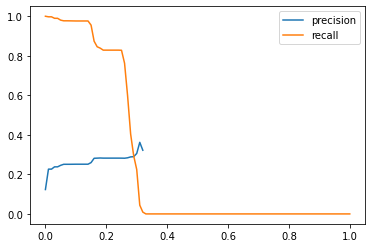

In [92]:
#@ INSPECTING THE CURVES:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()
# intersection at 0.3

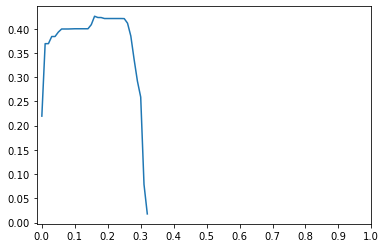

In [93]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

In [94]:
# tree-based model

In [95]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [96]:
y_pred = dt.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, y_pred)
# --> 0.822 ROC AUC score for basic decision tree

0.8216813866244842

In [97]:
y_pred

array([0.304348, 0.283019, 0.000000, ..., 0.000000, 0.000445, 0.000000])

In [98]:
# fit first-try model, get reference RMSE
rf = RandomForestClassifier(n_estimators = 10, 
                           random_state = 1, 
                           n_jobs = -1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=1)

In [99]:
y_pred = rf.predict_proba(X_valid) 
# indexing required because randomforest returns probas for each class
# y_pred[:,1] = "1" class --> input for roc_auc_score
roc_auc_score(y_valid, y_pred[:,1])
# --> 0.826 ROC AUC score for first-try randomforest model

0.8262534690447852

  0%|          | 0/19 [00:00<?, ?it/s]

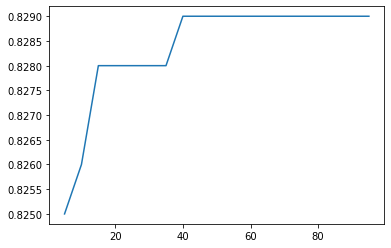

In [55]:
# try different values for n_estimators in random forest model and calculate ROC AUC scores
scores = []

for n in tqdm(range(5, 100, 5)):
    rf = RandomForestClassifier(n_estimators = n, 
                               random_state = 1, 
                               n_jobs = -1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_valid)
    score = roc_auc_score(y_valid, y_pred[:,1])
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

In [56]:
df_scores
# ROC AUC score basically stops improving at n_estimators=50 --> stick with this
# best ROC AUC score: 

,n_estimators,rmse
0,5,0.824614
1,10,0.826253
2,15,0.827508
3,20,0.827650
4,25,0.828036
5,30,0.828323
6,35,0.828480
7,40,0.828513
8,45,0.828701
9,50,0.828770


In [60]:
# try different scores.. and depths!
scores = []

for d in [5, 10, 15]:
    for n in range(10, 51, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid, y_pred)
        print(d, n, auc)

        scores.append((d, n, auc))
        
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)



5 10 0.8306685385817004
5 20 0.8311056676772907
5 30 0.8313999633513488
5 40 0.8319886430574209
5 50 0.8333024892426178
10 10 0.8367695662722877
10 20 0.8374043505228563
10 30 0.8376010791133255
10 40 0.8379554176003954
10 50 0.838055630646551
15 10 0.833957198610217
15 20 0.8349174585449946
15 30 0.8350289360364818
15 40 0.8351631963482532
15 50 0.8352750511520923


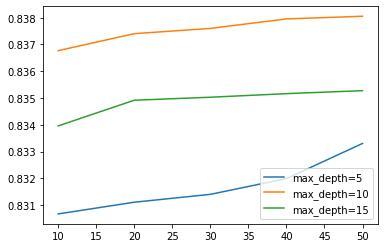

In [61]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()
# --> max_depth of 10 best out of these three at ROC AUC score of 0.839
# only 2% better than logistic regression baseline but still.. better

In [ ]:
# fancy model
# skipping xgboost and similar fancier models due to time constraint
# --> go ahead and deploy best performing randomforest setup

In [125]:
rf.predict(X_valid, type="prob")[:,1].tolist()

TypeError: predict() got an unexpected keyword argument 'type'

In [122]:
# print(classification_report(y_valid, y_pred[:,1]))  
